# C964 Predictive Model Training & Evaluation

## Setup

In [1]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import loguniform
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import (
    StackingRegressor,
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    PoissonRegressor,
    RANSACRegressor,
)
from sklearn.metrics import (
    PredictionErrorDisplay,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    median_absolute_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    cross_validate,
    cross_val_predict,
    train_test_split,
)
from sklearn.multioutput import (
    ClassifierChain,
    RegressorChain,
    MultiOutputClassifier,
    MultiOutputRegressor,
)
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklego.meta import ZeroInflatedRegressor

%matplotlib inline

sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("mako"))
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# Features file manually encodes the variable type for each selected column for use in training
meta = pd.read_csv("./data/features.csv")
meta

,variable,kind
0,HDD65,numerical
1,CDD65,numerical
2,TYPEHUQ,categorical
3,CELLAR,boolean
4,BASEFIN,boolean
...,...,...
89,EVCHRGHOME,boolean
90,NHSLDMEM,numerical
91,SQFTEST,numerical
92,DBT1,numerical


In [3]:
# Categorize variable by type
numerical_vars = meta.query("`kind` == 'numerical'")["variable"].tolist()
boolean_vars = meta.query("`kind` == 'boolean'")["variable"].tolist()
ordinal_vars = meta.query("`kind` == 'ordinal'")["variable"].tolist()
categorical_vars = meta.query("`kind` == 'categorical'")["variable"].tolist()

# Define target and feature variables
target_vars = ["TOTALBTU", "BTUEL", "BTUNG", "BTULP", "BTUFO", "BTUWD"]
feature_vars = [col for col in list(meta["variable"]) if col not in target_vars]

# Assign features by type
numerical_features = [col for col in numerical_vars if col in feature_vars]
boolean_features = [col for col in boolean_vars if col in feature_vars]
ordinal_features = [col for col in ordinal_vars if col in feature_vars]
categorical_features = [col for col in categorical_vars if col in feature_vars]

# Display counts of features by type
print("numerical_features", len(numerical_features))
print("boolean_features", len(boolean_features))
print("ordinal_features", len(ordinal_features))
print("categorical_features", len(categorical_features))
print("targets", len(target_vars))

numerical_features 36
boolean_features 22
ordinal_features 6
categorical_features 30
targets 6


In [4]:
# Define Pandas datatypes for variables
dtype = {}
for col in categorical_vars + ordinal_vars:
    dtype[col] = "category"
for col in boolean_vars:
    dtype[col] = "boolean"
for col in numerical_vars:
    dtype[col] = "float64"

# Import survey response dataset
data = pd.read_csv(
    "./data/recs2020_public_v5.csv",
    usecols=lambda c: c in (feature_vars + target_vars),
    dtype=dtype,
    na_values=["-2"],
)

targets = data[target_vars]
data = data[feature_vars]

data.head()

,HDD65,CDD65,TYPEHUQ,CELLAR,BASEFIN,ATTIC,ATTICFIN,STORIES,SIZEOFGARAGE,YEARMADERANGE,...,H2OAPT,WHEATSIZ,FUELH2O,MORETHAN1H2O,FUELH2O2,EVCHRGHOME,NHSLDMEM,SQFTEST,DBT1,DBT99
0,3844.0,1679.0,2,False,<NA>,False,<NA>,1,2,4,...,<NA>,3,1,False,NaN,<NA>,2.0,2100.0,92.9,21.6
1,3766.0,1458.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,5,...,False,2,1,False,NaN,<NA>,1.0,590.0,91.3,16.1
2,3819.0,1696.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,3,...,True,4,1,False,NaN,<NA>,1.0,900.0,92.9,21.6
3,2614.0,1718.0,2,False,<NA>,False,<NA>,2,2,5,...,<NA>,3,1,False,NaN,<NA>,2.0,2100.0,91.8,25.1
4,4219.0,1363.0,5,<NA>,<NA>,<NA>,<NA>,NaN,NaN,3,...,True,2,1,False,NaN,<NA>,2.0,800.0,81.8,13.0


In [5]:
def create_constant_imputer(fill_value):
    return SimpleImputer(
        strategy="constant", fill_value=fill_value, add_indicator=False
    )


def create_ordinal_transformer(*, fill_value="0", categories="auto"):
    return make_pipeline(
        create_constant_imputer(fill_value), OrdinalEncoder(categories=categories)
    )


default_ordinal_transformer = create_ordinal_transformer()

preprocess_ordinal = ColumnTransformer(
    [
        (
            "SIZEOFGARAGE",
            create_ordinal_transformer(categories=[["0", "1", "2", "3"]]),
            ["SIZEOFGARAGE"],
        ),
        (
            "YEARMADERANGE",
            create_ordinal_transformer(
                categories=[["1", "2", "3", "4", "5", "6", "7", "8", "9"]]
            ),
            ["YEARMADERANGE"],
        ),
        (
            "TYPEGLASS",
            create_ordinal_transformer(categories=[["1", "2", "3"]]),
            ["TYPEGLASS"],
        ),
        (
            "ADQINSUL",
            create_ordinal_transformer(categories=[["1", "2", "3", "4"]]),
            ["ADQINSUL"],
        ),
        (
            "WASHTEMP",
            create_ordinal_transformer(categories=[["0", "1", "2", "3", "0"]]),
            ["WASHTEMP"],
        ),
        (
            "WHEATSIZ",
            create_ordinal_transformer(categories=[["1", "2", "3", "4"]]),
            ["WHEATSIZ"],
        ),
    ],
    remainder=default_ordinal_transformer,
)


preprocess_categorical = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)


preprocess_boolean = make_pipeline(
    create_constant_imputer(fill_value=False),
    OneHotEncoder(andle_unknown="ignore", sparse_output=False),
)


normalized_transformer = make_pipeline(
    PowerTransformer(method="yeo-johnson", standardize=True)
)

standardized_transformer = make_pipeline(
    create_constant_imputer(fill_value=0), StandardScaler()
)

preprocess_numerical = ColumnTransformer(
    [("normalize", normalized_transformer, ["HDD65", "CDD65", "SQFTEST"])],
    remainder=standardized_transformer,
)

preprocessor = ColumnTransformer(
    [
        ("numerical", preprocess_numerical, numerical_features),
        ("boolean", preprocess_boolean, boolean_features),
        ("ordinal", preprocess_ordinal, ordinal_features),
        ("categorical", preprocess_categorical, categorical_features),
    ]
)
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                              SimpleImputer(fill_value=0,
                                                                                            strategy='constant')),
                                                                             ('standardscaler',
                                                                              StandardScaler())]),
                                                   transformers=[('normalize',
                                                                  Pipeline(steps=[('powertransformer',
                                                                                   PowerTransformer())]),
                                                                  ['HDD65',
                                                                   'CDD65',
                                                                   'SQFTEST'])]),
                                 ['HDD65', 'CDD65', 'BEDROOMS', 'NCOMBATH',
                                  'N...
                                 ['TYPEHUQ', 'STORIES', 'WALLTYPE', 'ROOFTYPE',
                                  'FUELPOOL', 'FUELTUB', 'TYPERFR1', 'TYPERFR2',
                                  'LOCRFRI2', 'UPRTFRZR', 'RANGEFUEL',
                                  'COOKTOPFUEL', 'OVENFUEL', 'OUTGRILLFUEL',
                                  'DWCYCLE', 'TOPFRONT', 'DRYRFUEL', 'EQUIPM',
                                  'FUELHEAT', 'EQUIPAUXTYPE', 'FUELAUX',
                                  'HUMIDTYPE', 'ACEQUIPM_PUB',
                                  'ACEQUIPAUXTYPE_PUB', 'DEHUMTYPE',
                                  'TYPETHERM', 'HEATCNTL', 'COOLCNTL',
                                  'FUELH2O', 'FUELH2O2'])])

In [6]:
target_var = "TOTALBTU"
target = targets[target_var]

regressor = HistGradientBoostingRegressor(max_iter=1000, early_stopping=True, random_state=42)
regressor

HistGradientBoostingRegressor(early_stopping=True, max_iter=10000,
                              random_state=42)

In [7]:
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import loguniform

class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

model = make_pipeline(preprocessor, regressor)

param_distributions = {
    # "histgradientboostingregressor__l2_regularization": loguniform(1e-6, 1e3),
    "histgradientboostingregressor__learning_rate": loguniform(0.001, 10),
    "histgradientboostingregressor__max_leaf_nodes": loguniform_int(2, 256),
    "histgradientboostingregressor__min_samples_leaf": loguniform_int(1, 100),
    # "histgradientboostingregressor__max_bins": loguniform_int(2, 255),
}

inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)

model = HalvingRandomSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    cv=inner_cv,
    min_resources=3500,
    n_jobs=4
)

cv_results = cross_validate(model, data, target, cv=outer_cv, n_jobs=4)

# model = make_pipeline(preprocessor, regressor)

# cv = KFold(n_splits=5, shuffle=True, random_state=42)
# cv_results = cross_validate(
#     model,
#     data,
#     target,
#     cv=cv,
#     scoring=["r2", "neg_mean_absolute_error"]
# )

# scores = pd.DataFrame({"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]})
# print(
#     "Coefficient of determination (R²):\n"
#     f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
# )
# print(
#     "Mean Absolute Error (MAE):\n"
#     f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
# )

# scores

Coefficient of determination (R²):
0.670 ± 0.032
Mean Absolute Error (MAE):
19407.668 ± 590.890


,R2,MAE
0,0.704395,18663.278340
1,0.665055,19547.814448
2,0.634513,20258.512609
3,0.699491,19099.291364
4,0.644694,19469.440827


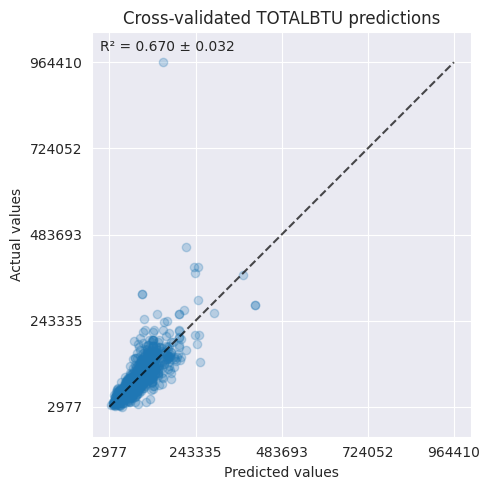

In [8]:
y_pred = cross_val_predict(
    model,
    data,
    target,
    cv=cv,
)

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    target,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={'alpha': 0.25},
    random_state=42
)
ax.set_title("Cross-validated TOTALBTU predictions")
ax.text(0.02, 0.98, f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}", ha='left', va='top', transform=ax.transAxes)
plt.tight_layout()
plt.show()

In [9]:
target_var = "BTUEL"
target = targets[target_var]

regressor = HistGradientBoostingRegressor(max_iter=10_000, early_stopping=True, random_state=42)
regressor

HistGradientBoostingRegressor(early_stopping=True, max_iter=10000,
                              random_state=42)

In [10]:
model = make_pipeline(preprocessor, regressor)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model,
    data,
    target,
    cv=cv,
    scoring=["r2", "neg_mean_absolute_error"],
)

scores = pd.DataFrame({"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]})
print(
    "Coefficient of determination (R²):\n"
    f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
)
print(
    "Mean Absolute Error (MAE):\n"
    f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
)

scores

Coefficient of determination (R²):
0.594 ± 0.025
Mean Absolute Error (MAE):
10208.735 ± 64.144


,R2,MAE
0,0.583767,10195.806374
1,0.604224,10172.407668
2,0.559501,10305.478071
3,0.626541,10232.342276
4,0.594148,10137.638868


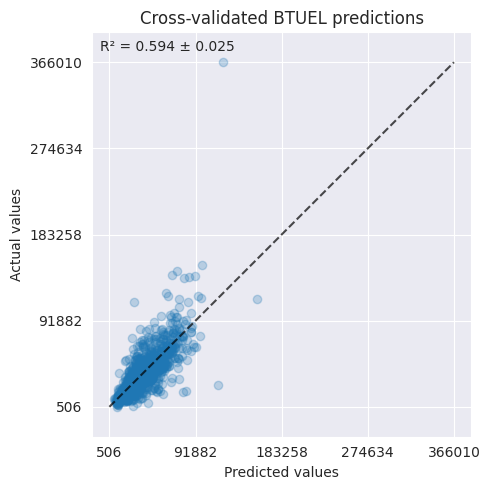

In [11]:
y_pred = cross_val_predict(
    model,
    data,
    target,
    cv=cv,
)

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    target,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={'alpha': 0.25},
    random_state=42
)
ax.set_title("Cross-validated BTUEL predictions")
ax.text(0.02, 0.98, f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}", ha='left', va='top', transform=ax.transAxes)
plt.tight_layout()
plt.show()

In [12]:
target_var = "BTUNG"
target = targets[target_var]

regressor = ZeroInflatedRegressor(
    classifier=HistGradientBoostingClassifier(max_iter=10_000, early_stopping=True, random_state=42),
    regressor= HistGradientBoostingRegressor(max_iter=10_000, early_stopping=True, random_state=42)
)
regressor

ZeroInflatedRegressor(classifier=HistGradientBoostingClassifier(early_stopping=True,
                                                                max_iter=10000,
                                                                random_state=42),
                      regressor=HistGradientBoostingRegressor(early_stopping=True,
                                                              max_iter=10000,
                                                              random_state=42))

In [13]:
model = make_pipeline(preprocessor, regressor)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model,
    data,
    target,
    cv=cv,
    scoring=["r2", "neg_mean_absolute_error"],
)

scores = pd.DataFrame({"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]})
print(
    "Coefficient of determination (R²):\n"
    f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
)
print(
    "Mean Absolute Error (MAE):\n"
    f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
)

scores

Coefficient of determination (R²):
0.774 ± 0.029
Mean Absolute Error (MAE):
10564.430 ± 613.014


,R2,MAE
0,0.818394,9603.666507
1,0.760389,11231.254336
2,0.742868,10679.464844
3,0.783922,10423.464435
4,0.763286,10884.300312


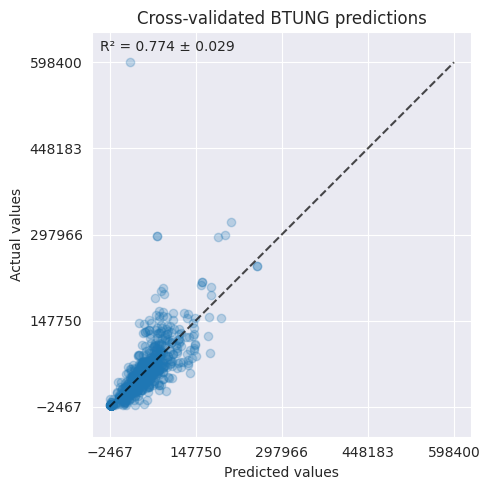

In [14]:
y_pred = cross_val_predict(
    model,
    data,
    target,
    cv=cv,
)

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    target,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={'alpha': 0.25},
    random_state=42
)
ax.set_title("Cross-validated BTUNG predictions")
ax.text(0.02, 0.98, f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}", ha='left', va='top', transform=ax.transAxes)
plt.tight_layout()
plt.show()

In [15]:
target_var = "BTULP"
target = targets[target_var]

regressor = ZeroInflatedRegressor(
    classifier=HistGradientBoostingClassifier(max_iter=10_000, early_stopping=True, random_state=42),
    regressor= HistGradientBoostingRegressor(max_iter=10_000, early_stopping=True, random_state=42)
)
regressor

ZeroInflatedRegressor(classifier=HistGradientBoostingClassifier(early_stopping=True,
                                                                max_iter=10000,
                                                                random_state=42),
                      regressor=HistGradientBoostingRegressor(early_stopping=True,
                                                              max_iter=10000,
                                                              random_state=42))

In [16]:
model = make_pipeline(preprocessor, regressor)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model,
    data,
    target,
    cv=cv,
    scoring=["r2", "neg_mean_absolute_error"]
)

scores = pd.DataFrame({"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]})
print(
    "Coefficient of determination (R²):\n"
    f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
)
print(
    "Mean Absolute Error (MAE):\n"
    f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
)

scores

Coefficient of determination (R²):
0.795 ± 0.028
Mean Absolute Error (MAE):
1600.855 ± 141.461


,R2,MAE
0,0.810185,1696.274947
1,0.746238,1630.840638
2,0.802816,1764.049871
3,0.818220,1486.247047
4,0.796710,1426.862340


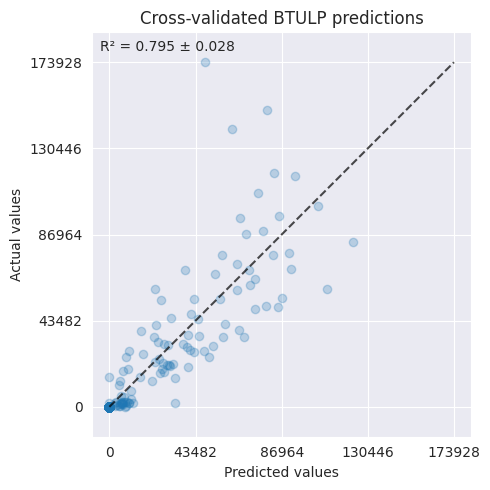

In [17]:
y_pred = cross_val_predict(
    model,
    data,
    target,
    cv=cv
)

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    target,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={'alpha': 0.25},
    random_state=42
)
ax.set_title("Cross-validated BTULP predictions")
ax.text(0.02, 0.98, f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}", ha='left', va='top', transform=ax.transAxes)
plt.tight_layout()
plt.show()

In [18]:
target_var = "BTUFO"
target = targets[target_var]

regressor = ZeroInflatedRegressor(
    classifier=HistGradientBoostingClassifier(max_iter=10_000, early_stopping=True, random_state=42),
    regressor= HistGradientBoostingRegressor(max_iter=10_000, early_stopping=True, random_state=42)
)
regressor

ZeroInflatedRegressor(classifier=HistGradientBoostingClassifier(early_stopping=True,
                                                                max_iter=10000,
                                                                random_state=42),
                      regressor=HistGradientBoostingRegressor(early_stopping=True,
                                                              max_iter=10000,
                                                              random_state=42))

In [19]:
model = make_pipeline(preprocessor, regressor)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model,
    data,
    target,
    cv=cv,
    scoring=["r2", "neg_mean_absolute_error"]
)

scores = pd.DataFrame({"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]})
print(
    "Coefficient of determination (R²):\n"
    f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
)
print(
    "Mean Absolute Error (MAE):\n"
    f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
)

scores

Coefficient of determination (R²):
0.845 ± 0.013
Mean Absolute Error (MAE):
1681.234 ± 212.351


,R2,MAE
0,0.835362,1760.245516
1,0.843602,1462.551349
2,0.839150,1893.674507
3,0.839643,1843.000640
4,0.868222,1446.697286


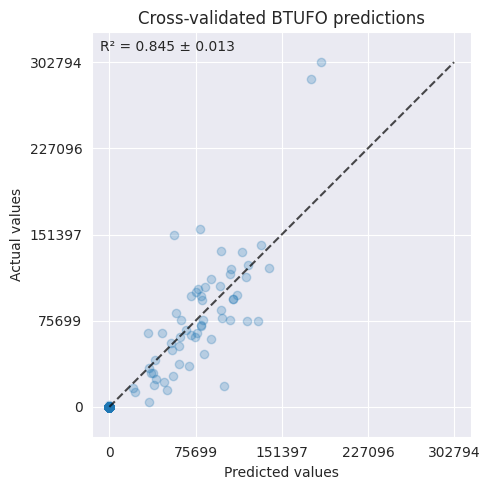

In [20]:
y_pred = cross_val_predict(
    model,
    data,
    target,
    cv=cv
)

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    target,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={'alpha': 0.25},
    random_state=42
)
ax.set_title("Cross-validated BTUFO predictions")
ax.text(0.02, 0.98, f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}", ha='left', va='top', transform=ax.transAxes)
plt.tight_layout()
plt.show()

In [21]:
target_var = "BTUWD"
target = targets[target_var]

regressor = ZeroInflatedRegressor(
    classifier=HistGradientBoostingClassifier(max_iter=10_000, early_stopping=True, random_state=42),
    regressor= HistGradientBoostingRegressor(max_iter=10_000, early_stopping=True, random_state=42)
)
regressor

ZeroInflatedRegressor(classifier=HistGradientBoostingClassifier(early_stopping=True,
                                                                max_iter=10000,
                                                                random_state=42),
                      regressor=HistGradientBoostingRegressor(early_stopping=True,
                                                              max_iter=10000,
                                                              random_state=42))

In [22]:
model = make_pipeline(preprocessor, regressor)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model,
    data,
    target,
    cv=cv,
    scoring=["r2", "neg_mean_absolute_error"]
)

scores = pd.DataFrame({"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]})
print(
    "Coefficient of determination (R²):\n"
    f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
)
print(
    "Mean Absolute Error (MAE):\n"
    f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
)

scores

Coefficient of determination (R²):
0.627 ± 0.016
Mean Absolute Error (MAE):
2095.330 ± 149.722


,R2,MAE
0,0.605598,2187.108021
1,0.630092,2137.915201
2,0.615620,2247.141203
3,0.645782,2040.093090
4,0.636510,1864.392994


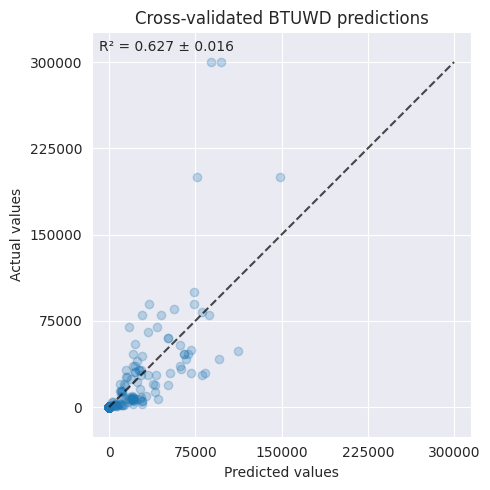

In [23]:
y_pred = cross_val_predict(
    model,
    data,
    target,
    cv=cv
)

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    target,
    y_pred=y_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={'alpha': 0.25},
    random_state=42
)
ax.set_title("Cross-validated BTUWD predictions")
ax.text(0.02, 0.98, f"R² = {scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}", ha='left', va='top', transform=ax.transAxes)
plt.tight_layout()
plt.show()

In [24]:
target = targets

regressor = RegressorChain(
    ZeroInflatedRegressor(
        classifier=HistGradientBoostingClassifier(max_iter=10_000, early_stopping=True, random_state=42),
        regressor= HistGradientBoostingRegressor(max_iter=10_000, early_stopping=True, random_state=42)
    ),
    order=[0, 4, 3, 2, 5, 1]
)
regressor

RegressorChain(base_estimator=ZeroInflatedRegressor(classifier=HistGradientBoostingClassifier(early_stopping=True,
                                                                                              max_iter=10000,
                                                                                              random_state=42),
                                                    regressor=HistGradientBoostingRegressor(early_stopping=True,
                                                                                            max_iter=10000,
                                                                                            random_state=42)),
               order=[0, 4, 3, 2, 5, 1])

In [25]:
model = make_pipeline(preprocessor, regressor)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model,
    data,
    target,
    cv=cv,
    scoring=["r2", "neg_mean_absolute_error"]
)

scores = pd.DataFrame({"R2": cv_results["test_r2"], "MAE": -cv_results["test_neg_mean_absolute_error"]})
print(
    "Coefficient of determination (R²):\n"
    f"{scores['R2'].mean():.3f} ± {scores['R2'].std():.3f}"
)
print(
    "Mean Absolute Error (MAE):\n"
    f"{scores['MAE'].mean():.3f} ± {scores['MAE'].std():.3f}"
)

scores

Coefficient of determination (R²):
0.713 ± 0.019
Mean Absolute Error (MAE):
7652.957 ± 186.896


,R2,MAE
0,0.721060,7447.438407
1,0.711090,7727.155753
2,0.686469,7934.590677
3,0.738918,7551.697232
4,0.707787,7603.900847


In [26]:
r2_raw_values = []
mae_raw_values = []

for fold, (train, test) in enumerate(cv.split(data)):
    model.fit(data.loc[train], target.loc[train])
    y_pred = model.predict(data.loc[test])
    
    r2_raw_values.append(r2_score(target.loc[test], y_pred, multioutput='raw_values'))
    mae_raw_values.append(mean_absolute_error(target.loc[test], y_pred, multioutput='raw_values'))

In [27]:
raw_scores = pd.DataFrame()

for idx, var in enumerate(['TOTALBTU', 'BTUEL', 'BTUNG', 'BTULP', 'BTUFO', 'BTUWD']):
        raw_scores[f"{var}_R2"] = [v[idx] for v in r2_raw_values]
        raw_scores[f"{var}_MAE"] = [v[idx] for v in mae_raw_values]

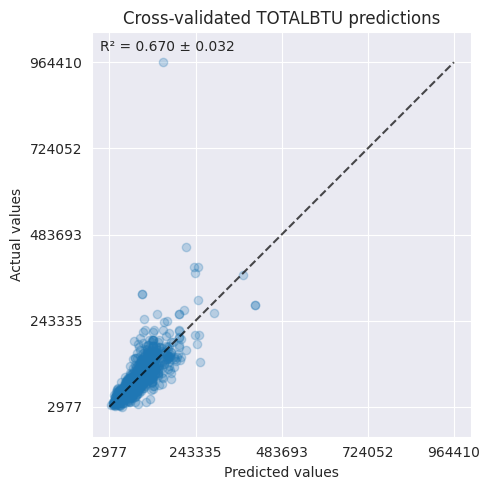

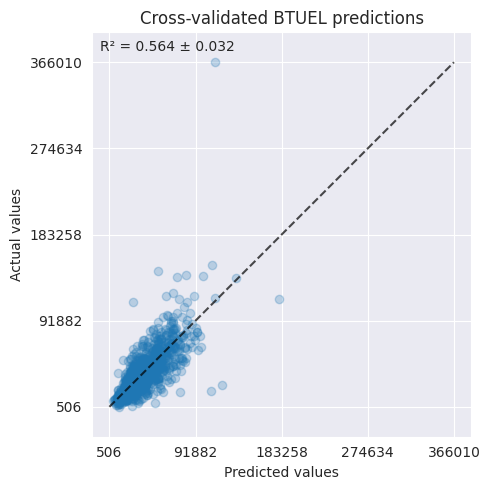

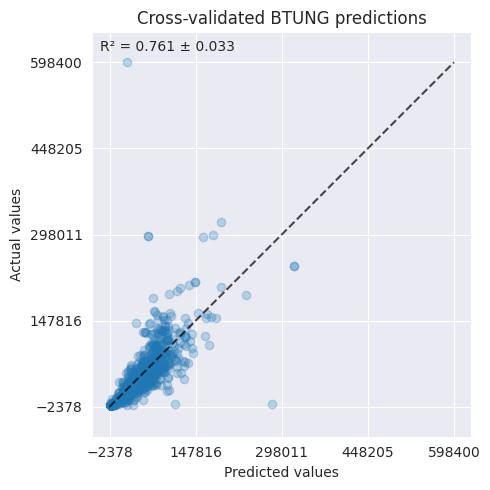

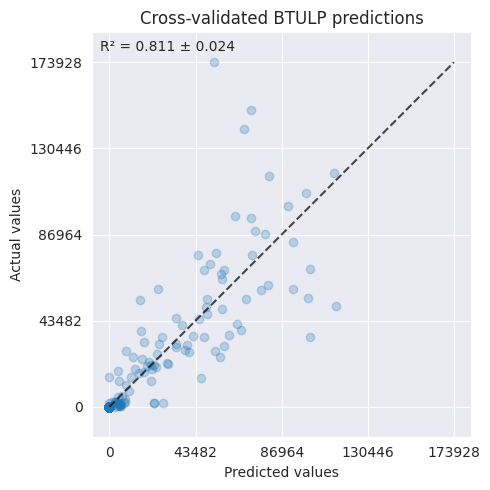

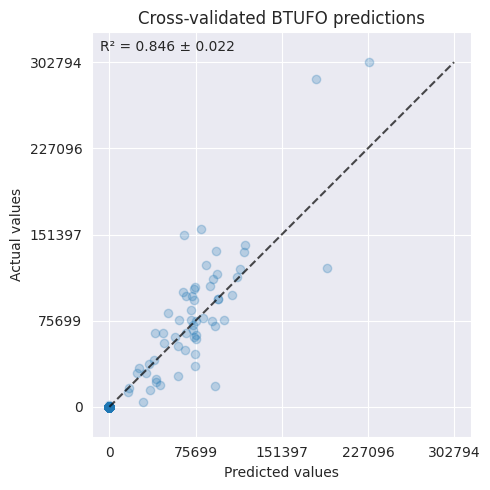

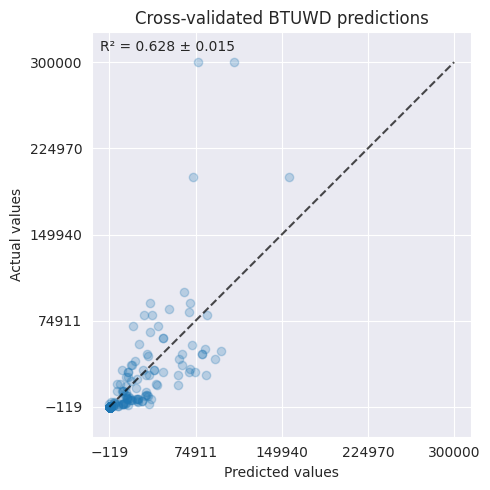

In [28]:
y_pred = cross_val_predict(
    model,
    data,
    target,
    cv=cv,
    n_jobs=-1
)

for idx, name in enumerate(['TOTALBTU', 'BTUEL', 'BTUNG', 'BTULP', 'BTUFO', 'BTUWD']):
    r2_score_col = f"{name}_R2"
    r2_score = f"{raw_scores[r2_score_col].mean():.3f} ± {raw_scores[r2_score_col].std():.3f}"
    
    _, ax = plt.subplots(figsize=(5, 5))
    display = PredictionErrorDisplay.from_predictions(
        target[name],
        y_pred=y_pred[:, idx],
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={'alpha': 0.25},
        random_state=42
    )
    ax.set_title(f"Cross-validated {name} predictions")
    ax.text(0.02, 0.98, f"R² = {r2_score}", ha='left', va='top', transform=ax.transAxes)
    plt.tight_layout()
    plt.show()